In [49]:
from mxnet import gluon
from mxnet import image
from mxnet import nd

In [50]:
data_shape = 256
batch_size = 32
#rgb_mean = nd.array([123, 117, 104])
data_dir='./data_ball/'

In [51]:
def get_iterators(data_shape, batch_size):
    class_names = ['basketball'] #类名称
    num_class = len(class_names)#类的个数
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),#3*256*256
        path_imgrec=data_dir+'dataset.rec',
        path_imgidx=data_dir+'dataset.idx',
        shuffle=True,
        #mean=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200)
    return train_iter,  class_names, num_class

train_data, class_names, num_class = get_iterators(
    data_shape, batch_size)

/home/qy/software/anaconda3/envs/gluon/lib/python3.6/site-packages/mxnet/recordio.py:370: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  header = header._replace(label=np.fromstring(s, np.float32, header.flag))


In [52]:
print(train_data)
print(class_names)
print(num_class)

['basketball']
1


In [53]:
batch = train_data.next()
print(batch)
print((batch.data[0][0:1]).shape)
print(batch.data[0].shape)
print(batch.label[0].shape)
print(batch.label[0][0:3].shape)
print(batch.label[0][0:3])

/home/qy/software/anaconda3/envs/gluon/lib/python3.6/site-packages/mxnet/recordio.py:370: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  header = header._replace(label=np.fromstring(s, np.float32, header.flag))


DataBatch: data shapes: [(32, 3, 256, 256)] label shapes: [(32, 1, 5)]
(1, 3, 256, 256)
(32, 3, 256, 256)
(32, 1, 5)
(3, 1, 5)

[[[0.         0.35470086 0.47843134 0.66239315 0.7333333 ]]

 [[0.         0.08185053 0.4094488  0.33807832 0.6968503 ]]

 [[0.         0.72981375 0.34894612 0.9192547  0.48946136]]]
<NDArray 3x1x5 @cpu(0)>


# 图示数据

In [54]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150#设置图片的显示大小
import matplotlib.pyplot as plt

In [55]:
def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
        fill=False, edgecolor=color, linewidth=linewidth)

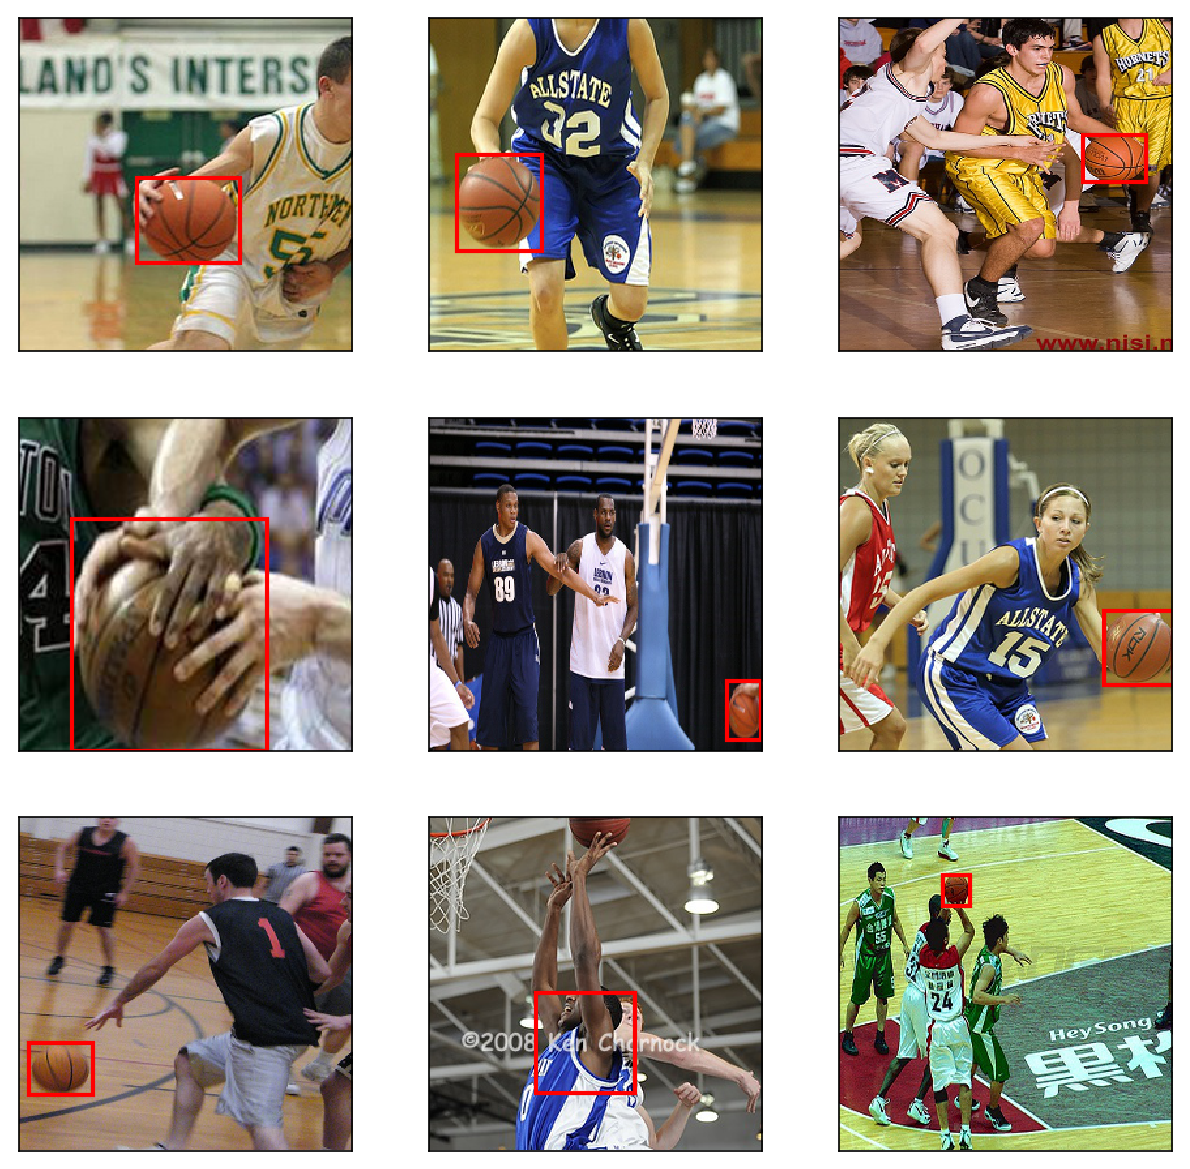

In [56]:
_, figs = plt.subplots(3, 3, figsize=(10,10))
for i in range(3):
    for j in range(3):        
        img, labels = batch.data[0][3*i+j], batch.label[0][3*i+j]
        # (3L, 256L, 256L) => (256L, 256L, 3L)
        img = img.transpose((1, 2, 0))
        img = img.clip(0,255).asnumpy()/255
        fig = figs[i][j]
        fig.imshow(img)
        for label in labels:
            rect = box_to_rect(label[1:5]*data_shape,'red',2)
            fig.add_patch(rect)                    
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
plt.show()

## SSD模型

### 锚框：默认的边界框

In [57]:
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

In [58]:
# shape: batch x channel x height x weight
n = 40
x = nd.random.uniform(shape=(1, 3, n, n))

y = MultiBoxPrior(x, sizes=[.5,.25,.1], ratios=[1,2,.5])

boxes = y.reshape((n, n, -1, 4))
print(boxes.shape)
# The first anchor box centered on (20, 20)
# its format is (x_min, y_min, x_max, y_max)
boxes[20, 20, 0, :]

(40, 40, 5, 4)



[0.2625 0.2625 0.7625 0.7625]
<NDArray 4 @cpu(0)>

我们可以画出以(20,20)为中心的所有锚框：

(5, 4)


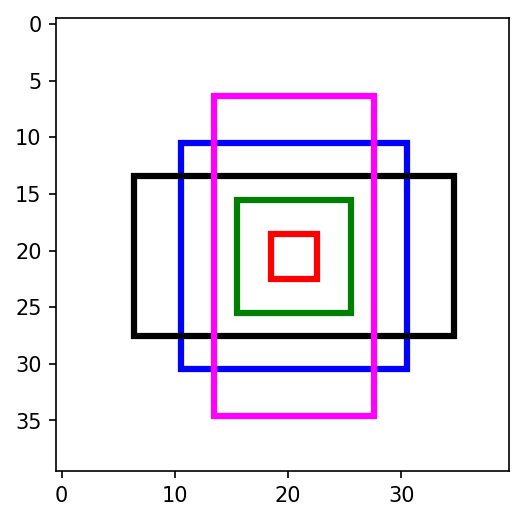

In [59]:
colors = ['blue', 'green', 'red', 'black', 'magenta']
plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :] 
print(anchors.shape)
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i,:]*n, colors[i]))
plt.show()

### 预测物体类别

In [60]:
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

In [61]:
cls_pred = class_predictor(5, 10)
cls_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
y = cls_pred(x)
y.shape

(2, 55, 20, 20)

### 预测边界框

In [62]:
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

In [63]:
box_pred = box_predictor(10)
box_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
y = box_pred(x)
y.shape

(2, 40, 20, 20)

### 减半模块

In [64]:
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2)) 
    return out

In [65]:
blk = down_sample(10)
blk.initialize()
x = nd.zeros((2, 3, 20, 20))
y = blk(x)
y.shape

(2, 10, 10, 10)

# 合并来自不同层的预测输出

In [66]:
x = nd.zeros((2, 8, 20, 20))
print('x:', x.shape)

cls_pred1 = class_predictor(5, 10)
cls_pred1.initialize()
y1 = cls_pred1(x)
print('Class prediction 1:', y1.shape)

ds = down_sample(16)
ds.initialize()
x = ds(x)
print('x:', x.shape)

cls_pred2 = class_predictor(3, 10)
cls_pred2.initialize()
y2 = cls_pred2(x)
print('Class prediction 2:', y2.shape)

x: (2, 8, 20, 20)
Class prediction 1: (2, 55, 20, 20)
x: (2, 16, 10, 10)
Class prediction 2: (2, 33, 10, 10)


In [67]:
def flatten_prediction(pred):
    return pred.transpose(axes=(0,2,3,1)).flatten()

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

In [68]:
flat_y1 = flatten_prediction(y1)
print('Flatten class prediction 1', flat_y1.shape)
flat_y2 = flatten_prediction(y2)
print('Flatten class prediction 2', flat_y2.shape)
y = concat_predictions([flat_y1, flat_y2])
print('Concat class predictions', y.shape)

Flatten class prediction 1 (2, 22000)
Flatten class prediction 2 (2, 3300)
Concat class predictions (2, 25300)


# 主体网络

In [69]:
def body():
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

In [70]:
bnet = body()
bnet.initialize()
x = nd.random.uniform(shape=(2,3,256,256))
y = bnet(x)
y.shape

(2, 64, 32, 32)

### 创建一个玩具SSD模型

现在我们可以创建一个玩具SSD模型了。我们称之为玩具是因为这个网络不管是层数还是锚框个数都比较小，仅仅适合之后我们之后使用的一个小数据集。但这个模型不会影响我们介绍SSD。
这个网络包含四块。主体网络，三个减半模块，以及五个物体类别和边框预测模块。其中预测分别应用在在主体网络输出，减半模块输出，和最后的全局池化层上。

In [71]:
def toy_ssd_model(num_anchors, num_classes):
    downsamplers = nn.Sequential()
    for _ in range(3):
        downsamplers.add(down_sample(128))
        
    class_predictors = nn.Sequential()
    box_predictors = nn.Sequential()    
    for _ in range(5):
        class_predictors.add(class_predictor(num_anchors, num_classes))
        box_predictors.add(box_predictor(num_anchors))

    model = nn.Sequential()
    model.add(body(), downsamplers, class_predictors, box_predictors)
    return model

### 计算预测

给定模型和每层预测输出使用的锚框大小和形状，我们可以定义前向函数。

In [72]:
def toy_ssd_forward(x, model, sizes, ratios, verbose=False):    
    body, downsamplers, class_predictors, box_predictors = model
    anchors, class_preds, box_preds = [], [], []
    # feature extraction    
    x = body(x)#feature extraction完毕
    for i in range(5):
        # predict
        anchors.append(MultiBoxPrior(
            x, sizes=sizes[i], ratios=ratios[i]))
        class_preds.append(
            flatten_prediction(class_predictors[i](x)))
        box_preds.append(
            flatten_prediction(box_predictors[i](x)))
        if verbose:
            print('Predict scale', i, x.shape, 'with', 
                  anchors[-1].shape[1], 'anchors')
        # down sample
        if i < 3:
            x = downsamplers[i](x)
        elif i == 3:
            x = nd.Pooling(
                x, global_pool=True, pool_type='max', 
                kernel=(x.shape[2], x.shape[3]))
    # concat data
    return (concat_predictions(anchors),
            concat_predictions(class_preds),
            concat_predictions(box_preds))

### 完整的模型

In [73]:
from mxnet import gluon
class ToySSD(gluon.Block):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes and ratios for 5 feature scales 这里有５个size和5个ratios，因为有５个不同大小的主网络
        self.sizes = [[.2,.272], [.37,.447], [.54,.619], 
                      [.71,.79], [.88,.961]]
        self.ratios = [[1,2,.5]]*5
        self.num_classes = num_classes
        self.verbose = verbose
        num_anchors = len(self.sizes[0]) + len(self.ratios[0]) - 1
        # use name_scope to guard the names
        with self.name_scope():
            self.model = toy_ssd_model(num_anchors, num_classes)

    def forward(self, x):
        anchors, class_preds, box_preds = toy_ssd_forward(
            x, self.model, self.sizes, self.ratios, 
            verbose=self.verbose)
        #print('class predictions:',class_preds.shape)
        # it is better to have class predictions reshaped for softmax computation       
        class_preds = class_preds.reshape(shape=(0, -1, self.num_classes+1))
        return anchors, class_preds, box_preds

我们看一下输入图片的形状是如何改变的，已经输出的形状。

In [74]:
net = ToySSD(num_classes=2, verbose=True)#这里设置类别为２　外加背景就是３
net.initialize()
x = batch.data[0][0:1]
print('Input:', x.shape)
anchors, class_preds, box_preds = net(x)
print('Output achors:', anchors.shape)
print('Output class predictions:', class_preds.shape)
print('Output box predictions:', box_preds.shape)

Input: (1, 3, 256, 256)
Predict scale 0 (1, 64, 32, 32) with 4096 anchors
Predict scale 1 (1, 128, 16, 16) with 1024 anchors
Predict scale 2 (1, 128, 8, 8) with 256 anchors
Predict scale 3 (1, 128, 4, 4) with 64 anchors
Predict scale 4 (1, 128, 1, 1) with 4 anchors
Output achors: (1, 5444, 4)
Output class predictions: (1, 5444, 3)
Output box predictions: (1, 21776)


## 训练

In [75]:
from mxnet.contrib.ndarray import MultiBoxTarget
def training_targets(anchors, class_preds, labels):
    class_preds = class_preds.transpose(axes=(0,2,1))
    #print(class_preds.shape)
    return MultiBoxTarget(anchors, labels, class_preds)

In [76]:
out = training_targets(anchors, class_preds, batch.label[0][0:1]) 
out

[
 [[0. 0. 0. ... 0. 0. 0.]]
 <NDArray 1x21776 @cpu(0)>, 
 [[0. 0. 0. ... 0. 0. 0.]]
 <NDArray 1x21776 @cpu(0)>, 
 [[0. 0. 0. ... 0. 0. 0.]]
 <NDArray 1x5444 @cpu(0)>]

In [77]:
batch.label[0][0:1]


[[[0.         0.35470086 0.47843134 0.66239315 0.7333333 ]]]
<NDArray 1x1x5 @cpu(0)>

然后我们可以定义需要的损失函数了。

对于分类问题，最常用的损失函数是之前一直使用的交叉熵。这里我们定义一个类似于交叉熵的损失，不同于交叉熵的定义
$\log(p_j)$，这里 $j$ 是真实的类别，且 $p_j$
是对于的预测概率。我们使用一个被称之为关注损失的函数，给定正的$\gamma$和$\alpha$，它的定义是

$$ - \alpha
(1-p_j)^{\gamma} \log(p_j) $$
下图我们演示不同$\gamma$导致的变化。可以看到，增加$\gamma$可以使得对正类预测值比较大时损失变小。

In [78]:
import numpy as np

def focal_loss(gamma, x):
    return - (1-x)**gamma*np.log(x)

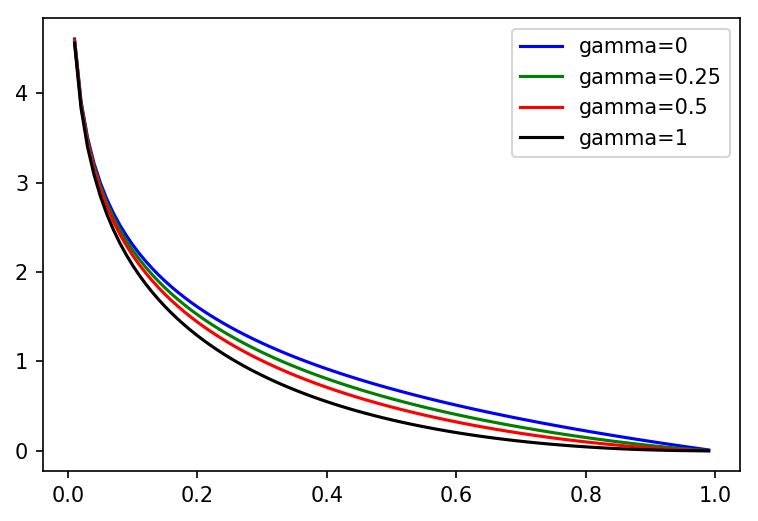

In [79]:
x = np.arange(0.01, 1, .01)
gammas = [0,.25,.5,1]
for i,g in enumerate(gammas):
    plt.plot(x, focal_loss(g,x), colors[i])

plt.legend(['gamma='+str(g) for g in gammas])
plt.show()

这个自定义的损失函数可以简单通过继承gluon.loss.Loss来实现。

In [80]:
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pj = output.pick(label, axis=self._axis, keepdims=True)
        loss = - self._alpha * ((1 - pj) ** self._gamma) * pj.log()
        return loss.mean(axis=self._batch_axis, exclude=True)

In [81]:
cls_loss = FocalLoss()
cls_loss

FocalLoss(batch_axis=0, w=None)

对于边框的预测是一个回归问题。通常可以选择平方损失函数（L2损失）$f(x)=x^2$。但这个损失对于比较大的误差的惩罚很高。我们可以采用稍微缓和一点绝对损失函数（L1损失）$f(x)=|x|$，它是随着误差线性增长，而不是平方增长。但这个函数在0点处导数不唯一，因此可能会影响收敛。一个通常的解决办法是在0点附近使用平方函数使得它更加平滑。它被称之为平滑L1损失函数。它通过一个参数$\sigma$来控制平滑的区域：
$$
f(x) =
    \begin{cases}
    (\sigma x)^2/2,& \text{if }x < 1/\sigma^2\\
|x|-0.5/\sigma^2,& \text{otherwise}
    \end{cases}
$$
我们图示不同的$\sigma$的平滑L1损失和L2损失的区别。

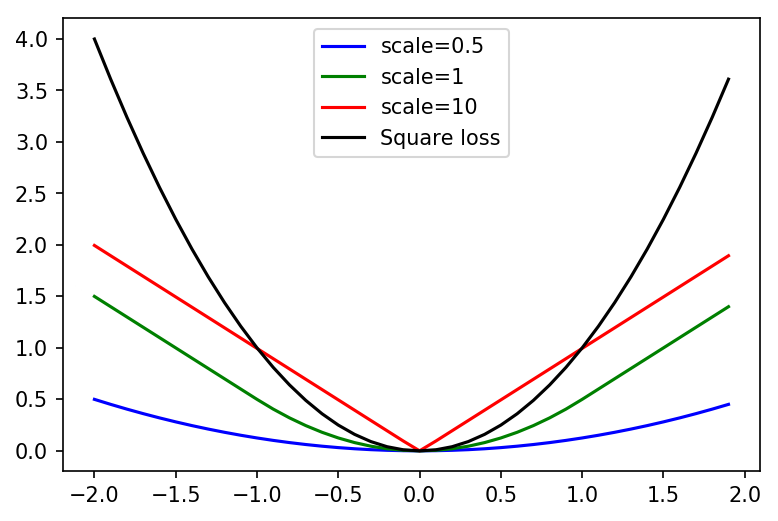

In [82]:
scales = [.5, 1, 10]
x = nd.arange(-2, 2, 0.1)

for i,s in enumerate(scales):
    y = nd.smooth_l1(x, scalar=s)
    plt.plot(x.asnumpy(), y.asnumpy(), color=colors[i])
plt.plot(x.asnumpy(), (x**2).asnumpy(), color=colors[len(scales)])
plt.legend(['scale='+str(s) for s in scales]+['Square loss'])
plt.show()

我们同样通过继承Loss来定义这个损失。同时它接受一个额外参数mask，这是用来屏蔽掉不需要被惩罚的负例样本。

In [83]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return loss.mean(self._batch_axis, exclude=True)

In [84]:
box_loss = SmoothL1Loss()
box_loss

SmoothL1Loss(batch_axis=0, w=None)

### 评估测量
对于分类好坏我们可以沿用之前的分类精度。评估边框预测的好坏的一个常用是是平均绝对误差。记得在[线性回归](../chapter_supervised-
learning/linear-regression-
scratch.md)我们使用了平均平方误差。但跟上面对损失函数的讨论一样，平方误差对于大的误差给予过大的值，从而数值上过于敏感。平均绝对误差就是将二次项替换成绝对值，具体来说就是预测的边框和真实边框在4个维度上的差值的绝对值。

In [85]:
from mxnet import metric

cls_metric = metric.Accuracy()#Computes accuracy classification score.
box_metric = metric.MAE() #Computes Mean Absolute Error (MAE) loss.

### 初始化模型和训练器

In [86]:
from mxnet import init
from mxnet import cpu

ctx = cpu(0)
# the CUDA implementation requres each image has at least 3 lables. 
# Padd two -1 labels for each instance 
train_data.reshape(label_shape=(3, 5))
#train_data = test_data.sync_label_shape(train_data)

net = ToySSD(num_class)
filename_4="checkpoints_4/ssd_net_4.params"
net.load_params(filename_4, ctx=ctx) #加载模型参数
#net.initialize(init.Xavier(magnitude=2), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 
                        'sgd', {'learning_rate': 0.01, 'wd': 5e-4})

In [87]:
batch.label[0][0]


[[0.         0.35470086 0.47843134 0.66239315 0.7333333 ]]
<NDArray 1x5 @cpu(0)>

In [88]:
import os
print(os.path.abspath('ssd_ball_detec.ipynb')) 
os.makedirs('checkpoints_4',exist_ok=True)
filename_4 = "checkpoints_4/ssd_net_4.params"

/home/qy/gluon-tutorials-zh/chapter_computer-vision/ssd_new/ssd_ball_detec.ipynb


In [89]:
import time
from mxnet import autograd
for epoch in range(100):
    # reset data iterators and metrics 
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    for i, batch in enumerate(train_data):
        x = batch.data[0].as_in_context(ctx)
        y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            anchors, class_preds, box_preds = net(x)
            box_target, box_mask, cls_target = training_targets(
                anchors, class_preds, y)
            #if i==1:
            #print('class_preds.shape',class_preds.shape)
            #print('class_preds[0][0]:',class_preds[0][0])
            #print('box_preds:',box_preds[0][0:4])
            #print('cls_target_shape:',cls_target.shape)
            #print('anchors_ture_label:',cls_target[0][0:20])
            # losses
            loss1 = cls_loss(class_preds, cls_target)#这一步将class_preds softmax处理
            loss2 = box_loss(box_preds, box_target, box_mask)
            loss = loss1 + loss2
        loss.backward()
        trainer.step(batch_size)
        # update metrics
        cls_metric.update([cls_target], [class_preds.transpose((0,2,1))])
        box_metric.update([box_target], [box_preds * box_mask])

    print('Epoch %2d, train %s %.2f, %s %.5f, time %.1f sec' % (
        epoch, *cls_metric.get(), *box_metric.get(), time.time()-tic
    ))
net.save_params(filename_4) 

/home/qy/software/anaconda3/envs/gluon/lib/python3.6/site-packages/mxnet/recordio.py:370: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  header = header._replace(label=np.fromstring(s, np.float32, header.flag))


Epoch  0, train accuracy 0.99, mae 0.00350, time 193.4 sec
Epoch  1, train accuracy 0.99, mae 0.00363, time 194.4 sec
Epoch  2, train accuracy 0.99, mae 0.00358, time 196.2 sec
Epoch  3, train accuracy 0.99, mae 0.00349, time 198.0 sec
Epoch  4, train accuracy 0.99, mae 0.00355, time 193.3 sec
Epoch  5, train accuracy 0.99, mae 0.00360, time 193.3 sec
Epoch  6, train accuracy 0.99, mae 0.00362, time 193.4 sec
Epoch  7, train accuracy 0.99, mae 0.00348, time 194.5 sec
Epoch  8, train accuracy 0.99, mae 0.00341, time 194.0 sec
Epoch  9, train accuracy 0.99, mae 0.00347, time 192.9 sec
Epoch 10, train accuracy 0.99, mae 0.00355, time 194.8 sec
Epoch 11, train accuracy 0.99, mae 0.00366, time 194.3 sec
Epoch 12, train accuracy 0.99, mae 0.00359, time 193.8 sec
Epoch 13, train accuracy 0.99, mae 0.00343, time 193.0 sec
Epoch 14, train accuracy 0.99, mae 0.00348, time 194.6 sec
Epoch 15, train accuracy 0.99, mae 0.00347, time 193.7 sec
Epoch 16, train accuracy 0.99, mae 0.00348, time 193.1 s

## 预测

在预测阶段，我们希望能把图片里面所有感兴趣的物体找出来。

我们先定一个数据读取和预处理函数。

In [45]:
def process_image(fname):
    with open(fname, 'rb') as f:
        im = image.imdecode(f.read())#Decode（解码） an image to an NDArray.
    # resize to data_shape
    data = image.imresize(im, data_shape, data_shape)
    # minus rgb mean
    data = data.astype('float32') #- rgb_mean
    # convert to batch x channel x height xwidth）
    return data.transpose((2,0,1)).expand_dims(axis=0), im

In [46]:
from mxnet.contrib.ndarray import MultiBoxDetection

def predict(x):
    anchors, cls_preds, box_preds = net(x.as_in_context(ctx))#模型预测主体
    cls_probs = nd.SoftmaxActivation(
        cls_preds.transpose((0,2,1)), mode='channel')

    return MultiBoxDetection(cls_probs, box_preds, anchors,
                             force_suppress=True, clip=False)

In [47]:
x, im = process_image('./n02802426_12868.JPEG')
out = predict(x)
out.shape
print(out[0][0:100])


[[ 0.          0.46537828  0.0889034  -0.2583676   0.9112741   1.1655905 ]
 [ 0.          0.42323142 -0.28798723  0.48836267  0.5548198   1.3739537 ]
 [ 0.          0.41221666 -0.08949406 -0.37808144  0.4325186   0.7687464 ]
 [ 0.          0.40412977 -0.15956384 -0.01214275  0.875521    0.75523615]
 [-1.          0.38010716  0.05700976  0.01689711  0.87818617  0.90773714]
 [ 0.          0.36787707  0.44337997  0.42055514  0.6117921   0.6027645 ]
 [ 0.          0.34528238  0.5900845   0.6382      0.8457076   0.8824168 ]
 [ 0.          0.34526533  0.40842265  0.7288254   0.6803737   1.0013758 ]
 [-1.          0.33809254 -0.2173005  -0.00757357  0.589079    0.7458314 ]
 [-1.          0.3297767   0.12894768  0.00577676  0.939974    0.8244612 ]
 [ 0.          0.3254799   0.86075026  0.17957199  1.0874252   0.34411657]
 [-1.          0.3039013  -0.09503728  0.16153526  1.0745099   0.81276214]
 [ 0.          0.29653227  0.2873352   0.3730514   0.46476987  0.6068997 ]
 [ 0.          0.2933370

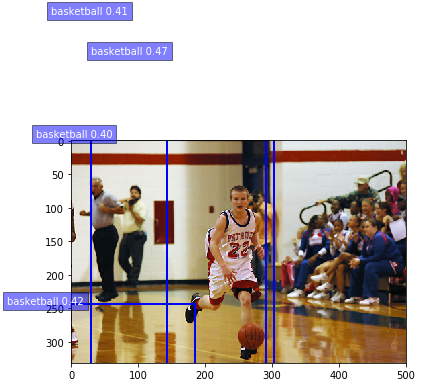

In [48]:
mpl.rcParams['figure.figsize'] = (6,6)

def display(im, out, threshold=0.5):    
    plt.imshow(im.asnumpy())
    for row in out:
        row = row.asnumpy()
        class_id, score = int(row[0]), row[1]
        if class_id < 0 or score < threshold:
            continue
        color = colors[class_id%len(colors)]
        box = row[2:6] * np.array([im.shape[0],im.shape[1]]*2)
        
        #测试row[2:6] * np.array([im.shape[0],im.shape[1]]*2)　中*2的含义
        #test_2=np.array([im.shape[0],im.shape[1]]*2)
        #print(test_2)
        
        rect = box_to_rect(nd.array(box), color, 2)
        plt.gca().add_patch(rect)
                        
        text = class_names[class_id] 
        plt.gca().text(box[0], box[1], 
                       '{:s} {:.2f}'.format(text, score),
                       bbox=dict(facecolor=color, alpha=0.5),
                       fontsize=10, color='white')
    plt.show()

display(im, out[0], threshold=0.37)